In [22]:
import pandas as pd
import json
import os

In [23]:
i_metrics_path = '~/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_metrics/instrument-peskavlp-vision+procedure+task+tracks-none=100-num_tracks=15-final.json'
i_metrics_path = '/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_metrics/instrument-peskavlp-vision+procedure+task+tracks-none=100-num_tracks=15-final.json'
a_metrics_path = i_metrics_path.replace('instrument', 'action')
t_metrics_path = i_metrics_path.replace('instrument', 'tissue')

with open(i_metrics_path, 'r') as f:
    i_metrics = json.load(f)

with open(a_metrics_path, 'r') as f:
    a_metrics = json.load(f)
    
with open(t_metrics_path, 'r') as f:
    t_metrics = json.load(f)

### Procedure + Task Tables

In [24]:
task_normalization_json = json.load(open('/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/data/iat/task_normalization.json'))
annotations_df = pd.read_csv('/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/data/iat_predictor_splits/full.csv').assign(task=lambda x: x['task'].map(task_normalization_json))
proc_df = annotations_df[['procedure', 'procedure_defn']].drop_duplicates().reset_index(drop=True)
task_df = annotations_df[['task', 'task_defn']].drop_duplicates().dropna().drop_duplicates('task').reset_index(drop=True)

In [25]:
for i in range(len(proc_df)):
    print(f"{proc_df.iloc[i]['procedure']}")
    print(f"{proc_df.iloc[i]['procedure_defn']}")
    print("-" * 100)

radical prostatectomy
Radical prostatectomy is a surgical procedure that involves the complete removal of the prostate gland along with some surrounding tissue, including the seminal vesicles and sometimes nearby lymph nodes. This procedure is primarily performed to treat localized prostate cancer and aims to eliminate cancerous cells while preserving as much surrounding healthy tissue as possible. It can be done through open surgery or minimally invasive techniques, such as laparoscopic or robotic-assisted surgery. Postoperative recovery may involve managing urinary incontinence and erectile dysfunction, which are common side effects.
----------------------------------------------------------------------------------------------------
simple prostatectomy
A simple prostatectomy is a surgical procedure aimed at removing the prostate gland and some surrounding tissue to alleviate symptoms caused by benign prostatic hyperplasia (BPH) or prostate cancer. This procedure is typically perform

In [26]:
annotations_df['procedure'].value_counts()

procedure
radical prostatectomy     822
simple prostatectomy      279
nephrectomy               244
partial nephrectomy        67
inguinal hernia repair     27
nephroureterectomy         11
Name: count, dtype: int64

In [27]:
for i in range(len(task_df)):
    # task = task_df.iloc[i]['task']
    # count = annotations_df[annotations_df['task'] == task]['task'].count()
    # defn = task_df.iloc[i]['task_defn']
    # print(f"{task} & {count} & {defn} \\" + '\\')
    print(f"{task_df.iloc[i]['task']}")
    # print(f"{annotations_df[annotations_df['task'] == task_df.iloc[i]['task']]['task'].count()}")
    print(f"Task Definition: {task_df.iloc[i]['task_defn']}")
    print("-" * 100)
    
    

Bladder Neck
Task Definition: The bladder neck is the region where the bladder connects to the urethra, and during surgical teaching, it is crucial to demonstrate the anatomy and function of this area, emphasizing its role in urinary continence and the potential complications that can arise from surgical manipulation, such as in prostatectomy procedures. Instruct trainees on identifying the bladder neck's landmarks and techniques for preserving its integrity during surgery to minimize postoperative complications.
----------------------------------------------------------------------------------------------------
SV
Task Definition: In urology surgery, the teaching step "SV" refers to "Surgical Visualization," which emphasizes the importance of clear and effective visualization of the surgical field through proper positioning, retraction, and use of appropriate lighting and magnification techniques to enhance the surgeon's ability to identify anatomical structures and perform precise in

In [29]:
annotations_df['task'].value_counts()

task
Lymph Node Dissection                         197
Dissection                                    181
VUA                                           154
Bowel Mobilization                            131
Bladder Neck                                  123
Adenoma Dissection                            115
Closing Bladder                               112
Dropping Bladder                              104
SV                                             54
SVs                                            50
Endopelvic Fascia                              32
Pedicle/NVB                                    24
SV/Vas                                         20
Cystotomy                                      17
Closing Peritoneum                             12
Peritoneal Flap and Mesh Pocket Dissection     11
Apical Dissection                              10
Oblique Checks                                  8
NVB                                             7
DVC                                          

### Table 1

In [53]:
import pandas as pd
import os
import json
import numpy as np

iat_metrics_dir = '/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_metrics'
models = ['surgvlp', 'peskavlp', 'hecvl']
input_types = ['vision', 'vision+procedure', 'vision+procedure+task']
iat_cols = ['instrument', 'action', 'tissue']

In [61]:
only_embs_rows = []
for iat_col in iat_cols:
    for model in models:
        for input_type in input_types:
            metrics_path = os.path.join(
                iat_metrics_dir,
                f'{iat_col}-{model}-{input_type}-none=100-f1_macro.json'
            )
            if os.path.exists(metrics_path):
                with open(metrics_path, 'r') as f:
                    metrics = json.load(f)
                only_embs_rows.append({
                    'IAT': iat_col,
                    'Model': model,
                    'Input Type': input_type,
                    'AUROC': metrics["auroc_mean"],
                    'AUROC-std': np.std(metrics["auroc_scores"]),
                    'F1': metrics["f1_mean"],
                    'F1-std': np.std(metrics["f1_scores"]),
                    'Precision': metrics["precision_mean"],
                    'Precision-std': np.std(metrics["precision_scores"]),
                    'Recall': metrics["recall_mean"],
                    'Recall-std': np.std(metrics["recall_scores"]),
                    'Num Tracks': 0
                })
only_embs_df = pd.DataFrame(only_embs_rows)
only_embs_df = only_embs_df.pivot_table(
    index=['Input Type', 'Model', 'Num Tracks'],
    columns='IAT',
    values=['AUROC', 'AUROC-std', 'F1', 'F1-std', 'Precision', 'Precision-std', 'Recall', 'Recall-std']
).reset_index()
only_embs_df.columns.name = None
only_embs_df = only_embs_df.rename(columns={
    'action': 'Action',
    'instrument': 'Instrument',
    'tissue': 'Tissue'
})
# only_embs_df = only_embs_df[['Input Type', 'Model', 'Num Tracks', 'Instrument', 'Action', 'Tissue']]
only_embs_df = only_embs_df[[
    ('Input Type', ''),
    ('Model', ''),
    ('Num Tracks', ''),
    ('AUROC', 'Instrument'),
    ('AUROC-std', 'Instrument'),
    ('AUROC', 'Action'),
    ('AUROC-std', 'Action'),
    ('AUROC', 'Tissue'),
    ('AUROC-std', 'Tissue'),
    ('F1', 'Instrument'),
    ('F1-std', 'Instrument'),
    ('F1', 'Action'),
    ('F1-std', 'Action'),
    ('F1', 'Tissue'),
    ('F1-std', 'Tissue'),
    ('Precision', 'Instrument'),
    ('Precision-std', 'Instrument'),
    ('Precision', 'Action'),
    ('Precision-std', 'Action'),
    ('Precision', 'Tissue'),
    ('Precision-std', 'Tissue'),
    ('Recall', 'Instrument'),
    ('Recall-std', 'Instrument'),
    ('Recall', 'Action'),
    ('Recall-std', 'Action'),
    ('Recall', 'Tissue'),
    ('Recall-std', 'Tissue')
]].round(2)
# only_embs_df 

In [62]:
hybrid_rows = []
all_num_tracks = [1, 5, 15, 30, 100, 'no_filter']
for iat_col in iat_cols:
    for model in models:
        for input_type in input_types:
            for num_tracks in all_num_tracks:
                if num_tracks == 'no_filter':
                    metrics_path = os.path.join(
                        iat_metrics_dir,
                        f'{iat_col}-{model}-{input_type}+tracks-none=100-no_filter_instrument_tracks-final.json'
                    )
                else:
                    metrics_path = os.path.join(
                        iat_metrics_dir,
                        f'{iat_col}-{model}-{input_type}+tracks-none=100-num_tracks={num_tracks}-f1_macro.json'
                    )
                if os.path.exists(metrics_path):
                    with open(metrics_path, 'r') as f:
                        metrics = json.load(f)
                    hybrid_rows.append({
                        'IAT': iat_col,
                        'Model': model,
                        'Input Type': input_type + ' + tracks',
                        'AUROC': metrics['auroc_mean'],
                        'AUROC-std': np.std(metrics["auroc_scores"]),
                        'F1': metrics['f1_mean'],
                        'F1-std': np.std(metrics["f1_scores"]),
                        'Precision': metrics['precision_mean'],
                        'Precision-std': np.std(metrics["precision_scores"]),
                        'Recall': metrics['recall_mean'],
                        'Recall-std': np.std(metrics["recall_scores"]),
                        'Num Tracks': num_tracks
                    })
hybrid_df = pd.DataFrame(hybrid_rows)
hybrid_df = hybrid_df.pivot_table(
    index=['Input Type', 'Model', 'Num Tracks'],
    columns='IAT',
    values=['AUROC', 'AUROC-std', 'F1', 'F1-std', 'Precision', 'Precision-std', 'Recall', 'Recall-std']
).reset_index()
hybrid_df.columns.name = None
hybrid_df = hybrid_df.rename(columns={
    'action': 'Action',
    'instrument': 'Instrument',
    'tissue': 'Tissue'
})
hybrid_df = hybrid_df[(hybrid_df['Input Type'] == 'vision+procedure+task + tracks')]
# hybrid_df = hybrid_df[['Input Type', 'Model', 'Num Tracks', 'Instrument', 'Action', 'Tissue']]
hybrid_df = hybrid_df[[
    ('Input Type', ''),
    ('Model', ''),
    ('Num Tracks', ''),
    ('AUROC', 'Instrument'),
    ('AUROC-std', 'Instrument'),
    ('AUROC', 'Action'),
    ('AUROC-std', 'Action'),
    ('AUROC', 'Tissue'),
    ('AUROC-std', 'Tissue'),
    ('F1', 'Instrument'),
    ('F1-std', 'Instrument'),
    ('F1', 'Action'),
    ('F1-std', 'Action'),
    ('F1', 'Tissue'),
    ('F1-std', 'Tissue'),
    ('Precision', 'Instrument'),
    ('Precision-std', 'Instrument'),
    ('Precision', 'Action'),
    ('Precision-std', 'Action'),
    ('Precision', 'Tissue'),
    ('Precision-std', 'Tissue'),
    ('Recall', 'Instrument'),
    ('Recall-std', 'Instrument'),
    ('Recall', 'Action'),
    ('Recall-std', 'Action'),
    ('Recall', 'Tissue'),
    ('Recall-std', 'Tissue')
]].round(2)
# hybrid_df

In [66]:
full_df = pd.concat([only_embs_df, hybrid_df]).reset_index(drop=True)
full_df

# vision, vison+procedure, vision+procedure+task, vision+procedure+task+tracks
df1 = full_df.copy()
df1 = df1[df1['Num Tracks'].isin([0, 15])].reset_index(drop=True)
df1 = df1[[
    ('Input Type', ''),
    ('Model', ''),
    # ('Num Tracks', ''),
    ('AUROC', 'Instrument'),
    ('AUROC-std', 'Instrument'),
    ('AUROC', 'Action'),
    ('AUROC-std', 'Action'),
    ('AUROC', 'Tissue'),    
    ('AUROC-std', 'Tissue'),
    ('F1', 'Instrument'),
    ('F1-std', 'Instrument'),
    ('F1', 'Action'),
    ('F1-std', 'Action'),
    ('F1', 'Tissue'),
    ('F1-std', 'Tissue'),
    ('Precision', 'Instrument'),
    ('Precision-std', 'Instrument'),
    ('Precision', 'Action'),
    ('Precision-std', 'Action'),
    ('Precision', 'Tissue'),
    ('Precision-std', 'Tissue'),
    ('Recall', 'Instrument'),
    ('Recall-std', 'Instrument'),
    ('Recall', 'Action'),
    ('Recall-std', 'Action'),
    ('Recall', 'Tissue'),
    ('Recall-std', 'Tissue')
]].round(2)
display(df1[[('Input Type', ''), ('Model', ''), ('F1', 'Instrument'), ('F1-std', 'Instrument'), ('Precision', 'Instrument'), ('Precision-std', 'Instrument'), ('Recall', 'Instrument'), ('Recall-std', 'Instrument')]])
display(df1[[('Input Type', ''), ('Model', ''),('F1', 'Action'), ('F1-std', 'Action'), ('Precision', 'Action'), ('Precision-std', 'Action'), ('Recall', 'Action'), ('Recall-std', 'Action')]])
display(df1[[('Input Type', ''), ('Model', ''),('F1', 'Tissue'), ('F1-std', 'Tissue'), ('Precision', 'Tissue'), ('Precision-std', 'Tissue'), ('Recall', 'Tissue'), ('Recall-std', 'Tissue')]])

,Input Type,Model,F1,F1-std,Precision,Precision-std,Recall,Recall-std
IAT,,,Instrument,Instrument,Instrument,Instrument,Instrument,Instrument
0,vision,hecvl,0.34,0.05,0.35,0.06,0.35,0.05
1,vision,peskavlp,0.32,0.03,0.33,0.03,0.32,0.03
2,vision,surgvlp,0.28,0.02,0.29,0.03,0.29,0.02
3,vision+procedure,hecvl,0.29,0.04,0.30,0.05,0.30,0.05
4,vision+procedure,peskavlp,0.29,0.05,0.30,0.05,0.29,0.05
5,vision+procedure,surgvlp,0.30,0.02,0.31,0.03,0.31,0.02
6,vision+procedure+task,hecvl,0.33,0.06,0.33,0.07,0.34,0.07
7,vision+procedure+task,peskavlp,0.34,0.04,0.37,0.04,0.34,0.05
8,vision+procedure+task,surgvlp,0.31,0.05,0.32,0.05,0.31,0.04


,Input Type,Model,F1,F1-std,Precision,Precision-std,Recall,Recall-std
IAT,,,Action,Action,Action,Action,Action,Action
0,vision,hecvl,0.10,0.01,0.11,0.02,0.11,0.02
1,vision,peskavlp,0.10,0.03,0.10,0.04,0.10,0.03
2,vision,surgvlp,0.09,0.01,0.09,0.01,0.09,0.01
3,vision+procedure,hecvl,0.11,0.01,0.11,0.01,0.12,0.01
4,vision+procedure,peskavlp,0.10,0.02,0.09,0.02,0.10,0.02
5,vision+procedure,surgvlp,0.10,0.02,0.11,0.02,0.11,0.02
6,vision+procedure+task,hecvl,0.10,0.02,0.10,0.02,0.11,0.02
7,vision+procedure+task,peskavlp,0.11,0.02,0.12,0.02,0.11,0.02
8,vision+procedure+task,surgvlp,0.12,0.03,0.13,0.04,0.12,0.03


,Input Type,Model,F1,F1-std,Precision,Precision-std,Recall,Recall-std
IAT,,,Tissue,Tissue,Tissue,Tissue,Tissue,Tissue
0,vision,hecvl,0.30,0.04,0.32,0.05,0.31,0.04
1,vision,peskavlp,0.32,0.04,0.34,0.04,0.32,0.04
2,vision,surgvlp,0.30,0.01,0.34,0.03,0.29,0.01
3,vision+procedure,hecvl,0.32,0.03,0.34,0.03,0.32,0.02
4,vision+procedure,peskavlp,0.30,0.04,0.32,0.04,0.30,0.04
5,vision+procedure,surgvlp,0.29,0.03,0.30,0.03,0.29,0.03
6,vision+procedure+task,hecvl,0.33,0.04,0.34,0.05,0.34,0.04
7,vision+procedure+task,peskavlp,0.33,0.04,0.35,0.04,0.33,0.04
8,vision+procedure+task,surgvlp,0.33,0.04,0.35,0.04,0.33,0.04


### Confidence Thresholding

In [81]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
import numpy as np
import ast

# --- 1. Load Data ---
pred_path = '~/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_predictions/peskavlp-vision+procedure+task+tracks-none=100-num_tracks=15-final.csv'
# pred_path = '~/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_predictions/peskavlp-vision+procedure+task-none=100-final-with_conf.csv'


pred_df = pd.read_csv(pred_path)

# --- 2. Encode Text Labels to Numbers ---
# Encode 'instrument'
i_encoder = LabelEncoder().fit(pd.concat([pred_df['instrument'], pred_df['instrument_pred']]).dropna().unique())
pred_df['instrument_encoded'] = pred_df['instrument'].apply(lambda x: i_encoder.transform([x])[0] if pd.notna(x) and x in i_encoder.classes_ else -1)
pred_df['instrument_pred_encoded'] = pred_df['instrument_pred'].apply(lambda x: i_encoder.transform([x])[0] if pd.notna(x) and x in i_encoder.classes_ else -1)

# Encode 'action'
a_encoder = LabelEncoder().fit(pd.concat([pred_df['action'], pred_df['action_pred']]).dropna().unique())
pred_df['action_encoded'] = pred_df['action'].apply(lambda x: a_encoder.transform([x])[0] if pd.notna(x) and x in a_encoder.classes_ else -1)
pred_df['action_pred_encoded'] = pred_df['action_pred'].apply(lambda x: a_encoder.transform([x])[0] if pd.notna(x) and x in a_encoder.classes_ else -1)

# Encode 'tissue'
t_encoder = LabelEncoder().fit(pd.concat([pred_df['tissue'], pred_df['tissue_pred']]).dropna().unique())
pred_df['tissue_encoded'] = pred_df['tissue'].apply(lambda x: t_encoder.transform([x])[0] if pd.notna(x) and x in t_encoder.classes_ else -1)
pred_df['tissue_pred_encoded'] = pred_df['tissue_pred'].apply(lambda x: t_encoder.transform([x])[0] if pd.notna(x) and x in t_encoder.classes_ else -1)


# --- 3. Calculate Metrics Across Confidence Levels ---
i_n = len(pred_df[pred_df['instrument'].notna()])
a_n = len(pred_df[pred_df['action'].notna()])
t_n = len(pred_df[pred_df['tissue'].notna()])

confidence_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
metrics = []

import warnings
warnings.filterwarnings('ignore')

for confidence_level in confidence_levels:
    # print(f"CONFIDENCE LEVEL: {confidence_level}")
    i_df = pred_df[(pred_df['instrument'].notna()) & (pred_df['instrument_conf'] > confidence_level)]
    a_df = pred_df[(pred_df['action'].notna()) & (pred_df['action_conf'] > confidence_level)]
    t_df = pred_df[(pred_df['tissue'].notna()) & (pred_df['tissue_conf'] > confidence_level)]
    
    row_dict = {'confidence_level': confidence_level}
    
    # We use a loop to avoid repeating code for each category
    for prefix, df, total_count, encoder in [('instrument', i_df, i_n, i_encoder), ('action', a_df, a_n, a_encoder), ('tissue', t_df, t_n, t_encoder)]:
        pct = len(df) / total_count if total_count > 0 else 0
        row_dict[f'{prefix}_pct'] = pct
        if not df.empty:
            true_labels = df[f'{prefix}_encoded']
            pred_labels = df[f'{prefix}_pred_encoded']
            
            # --- NEW: Calculate average confidence ---
            row_dict[f'{prefix}_avg_conf'] = df[f'{prefix}_conf'].mean()
            
            row_dict[f'{prefix}_f1'] = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
            row_dict[f'{prefix}_precision'] = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
            row_dict[f'{prefix}_recall'] = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
            
            # --- ROC AUC Calculation ---
            if f'{prefix}_pred_probs' in df.columns:
                true_labels_binarized = label_binarize(true_labels, classes=range(len(encoder.classes_)))
                
                ordered_classes = encoder.classes_
                def get_ordered_probs(prob_dict_str):
                    prob_dict = ast.literal_eval(prob_dict_str)
                    return [prob_dict.get(cls, 0) for cls in ordered_classes]

                pred_probas = np.array(df[f'{prefix}_pred_probs'].apply(get_ordered_probs).to_list())
                
                
                if (true_labels_binarized.shape[1] == pred_probas.shape[1]) and pct > 0.01:
                    row_dict[f'{prefix}_roc_auc'] = roc_auc_score(
                        true_labels_binarized, 
                        pred_probas, 
                        multi_class='ovo', 
                        average='weighted'
                    )
                else:
                    row_dict[f'{prefix}_roc_auc'] = np.nan

        else:
            # --- NEW: Handle empty case for avg_conf ---
            row_dict[f'{prefix}_avg_conf'] = np.nan
            row_dict[f'{prefix}_f1'] = np.nan
            row_dict[f'{prefix}_precision'] = np.nan
            row_dict[f'{prefix}_recall'] = np.nan
            row_dict[f'{prefix}_roc_auc'] = np.nan
            
    metrics.append(row_dict)

# --- 4. Display and Save Results ---
metrics_df = pd.DataFrame(metrics)

metrics_df = metrics_df.round(2).sort_values(by='confidence_level', ascending=False)
metrics_df = metrics_df[['confidence_level', 'instrument_pct', 'instrument_roc_auc', 'action_pct', 'action_roc_auc', 'tissue_pct', 'tissue_roc_auc']]
metrics_df

,confidence_level,instrument_pct,instrument_roc_auc,action_pct,action_roc_auc,tissue_pct,tissue_roc_auc
9,0.9,0.00,NaN,0.00,NaN,0.00,NaN
8,0.8,0.01,NaN,0.00,NaN,0.00,NaN
7,0.7,0.03,0.82,0.00,NaN,0.02,0.81
6,0.6,0.06,0.73,0.00,NaN,0.07,0.77
5,0.5,0.14,0.76,0.00,NaN,0.18,0.82
4,0.4,0.29,0.75,0.02,0.63,0.38,0.82
3,0.3,0.66,0.74,0.08,0.66,0.72,0.82
2,0.2,0.98,0.74,0.34,0.67,0.96,0.81
1,0.1,1.00,0.74,0.85,0.64,1.00,0.81
0,0.0,1.00,0.74,1.00,0.64,1.00,0.81


### Per Procedure/Task/Trainer

In [67]:
min_procedure_count = 50
min_task_count = 50
min_trainer_count = 0

In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
import numpy as np
import ast

# --- 1. Load Data ---
pred_path = '~/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_predictions/peskavlp-vision+procedure+task+tracks-none=100-num_tracks=15-final.csv'
pred_df = pd.read_csv(pred_path)


trainers_path = '/home/firdavs/surgery/annotations/Overview of Cases.xlsx'
trainers_df = pd.read_excel(trainers_path).rename(columns={'LFB Case #': 'case', 'Attending ID': 'trainer'})[['case', 'trainer']]

pred_df['case'] = pred_df['cvid'].apply(lambda x: int(x.split('_')[0][1:]))
pred_df = pred_df.merge(trainers_df, on='case', how='left')

# --- 2. Encode Text Labels to Numbers ---
# Encode 'instrument'
i_encoder = LabelEncoder().fit(pd.concat([pred_df['instrument'], pred_df['instrument_pred']]).dropna().unique())
pred_df['instrument_encoded'] = pred_df['instrument'].apply(lambda x: i_encoder.transform([x])[0] if pd.notna(x) and x in i_encoder.classes_ else -1)
pred_df['instrument_pred_encoded'] = pred_df['instrument_pred'].apply(lambda x: i_encoder.transform([x])[0] if pd.notna(x) and x in i_encoder.classes_ else -1)

# Encode 'action'
a_encoder = LabelEncoder().fit(pd.concat([pred_df['action'], pred_df['action_pred']]).dropna().unique())
pred_df['action_encoded'] = pred_df['action'].apply(lambda x: a_encoder.transform([x])[0] if pd.notna(x) and x in a_encoder.classes_ else -1)
pred_df['action_pred_encoded'] = pred_df['action_pred'].apply(lambda x: a_encoder.transform([x])[0] if pd.notna(x) and x in a_encoder.classes_ else -1)

# Encode 'tissue'
t_encoder = LabelEncoder().fit(pd.concat([pred_df['tissue'], pred_df['tissue_pred']]).dropna().unique())
pred_df['tissue_encoded'] = pred_df['tissue'].apply(lambda x: t_encoder.transform([x])[0] if pd.notna(x) and x in t_encoder.classes_ else -1)
pred_df['tissue_pred_encoded'] = pred_df['tissue_pred'].apply(lambda x: t_encoder.transform([x])[0] if pd.notna(x) and x in t_encoder.classes_ else -1)


# --- 3. Calculate Metrics  ---
conditioners = ['procedure', 'task', 'trainer']
metrics_dfs = []

import warnings
warnings.filterwarnings('ignore')

for conditioner in conditioners:
    metrics_rows = []
    # print(f"CONFIDENCE LEVEL: {confidence_level}")
    # i_df_all = pred_df[(pred_df['instrument'].notna())].copy()
    # a_df_all = pred_df[(pred_df['action'].notna())].copy()
    # t_df_all = pred_df[(pred_df['tissue'].notna())].copy()
    
    df_all = pred_df.copy()
    
    if conditioner == 'procedure':
        df_all = df_all[df_all['procedure'].isin((df_all.value_counts(subset='procedure') >= min_procedure_count).replace(False, np.nan).dropna().index)].reset_index(drop=True)
    elif conditioner == 'task':
        df_all = df_all[df_all['task'].isin((df_all.value_counts(subset='task') >= min_task_count).replace(False, np.nan).dropna().index)].reset_index(drop=True)
    elif conditioner == 'trainer':
        df_all = df_all[df_all['trainer'].isin((df_all.value_counts(subset='trainer') >= min_trainer_count).replace(False, np.nan).dropna().index)].reset_index(drop=True)
    else:
        raise ValueError(f"Invalid conditioner. Only 'procedure' and 'task' are allowed.")
    
    for prefix, encoder in [('instrument', i_encoder), ('action', a_encoder), ('tissue', t_encoder)]:
        for condition_value in df_all[conditioner].unique():
            df_condition = df_all[df_all[conditioner] == condition_value].copy()
            df_condition = df_condition[(df_condition[prefix].notna())]
            n = len(df_condition)
            total_count = len(df_all)
            pct = n / total_count if total_count > 0 else 0
            row_dict = {
                'iat': prefix,
                'conditioner': conditioner,
                'condition_value': condition_value,
                'total_count': total_count,
                'n': n,
                'pct': pct
            }
            if not df_condition.empty:
                true_labels = df_condition[f'{prefix}_encoded']
                pred_labels = df_condition[f'{prefix}_pred_encoded']
                
                row_dict['f1'] = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
                row_dict['precision'] = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
                row_dict['recall'] = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
                
                # --- ROC AUC Calculation ---
                if f'{prefix}_pred_probs' in df_condition.columns:
                    true_labels_binarized = label_binarize(true_labels, classes=range(len(encoder.classes_)))
                    
                    ordered_classes = encoder.classes_
                    def get_ordered_probs(prob_dict_str):
                        prob_dict = ast.literal_eval(prob_dict_str)
                        return [prob_dict.get(cls, 0) for cls in ordered_classes]

                    pred_probas = np.array(df_condition[f'{prefix}_pred_probs'].apply(get_ordered_probs).to_list())
                    
                    if (true_labels_binarized.shape[1] == pred_probas.shape[1]) and pct > 0.01:
                        row_dict[f'auc'] = roc_auc_score(
                            true_labels_binarized, 
                            pred_probas, 
                            multi_class='ovo', 
                            average='weighted'
                        )
                    else:
                        row_dict['auc'] = np.nan

            else:
                # --- NEW: Handle empty case for avg_conf ---
                row_dict['f1'] = np.nan
                row_dict['precision'] = np.nan
                row_dict['recall'] = np.nan
                row_dict['auc'] = np.nan
            
            metrics_rows.append(row_dict)
    metrics_dfs.append(pd.DataFrame(metrics_rows))

In [ ]:
# Procedure
metrics_dfs[0]

,iat,conditioner,condition_value,total_count,n,pct,f1,precision,recall,auc
0,instrument,procedure,nephrectomy,1412,51,0.036119,0.222876,0.261574,0.205270,0.692322
1,instrument,procedure,simple prostatectomy,1412,85,0.060198,0.222464,0.256190,0.239132,0.622110
2,instrument,procedure,radical prostatectomy,1412,171,0.121105,0.218346,0.263734,0.207962,0.706724
3,instrument,procedure,partial nephrectomy,1412,29,0.020538,0.282828,0.258454,0.312281,0.540805
4,action,procedure,nephrectomy,1412,136,0.096317,0.020096,0.013650,0.045000,0.471496
5,action,procedure,simple prostatectomy,1412,179,0.126771,0.061580,0.049485,0.103538,0.695101
6,action,procedure,radical prostatectomy,1412,503,0.356232,0.044385,0.047095,0.069851,0.635332
7,action,procedure,partial nephrectomy,1412,38,0.026912,0.060275,0.053782,0.089636,0.508605
8,tissue,procedure,nephrectomy,1412,88,0.062323,0.119156,0.121027,0.125750,0.609900
9,tissue,procedure,simple prostatectomy,1412,82,0.058074,0.151623,0.164773,0.166079,0.673526


In [ ]:
# Task
metrics_dfs[1]

,iat,conditioner,condition_value,total_count,n,pct,f1,precision,recall,auc
0,instrument,task,Bowel Mobilization,962,34,0.035343,0.342396,0.414286,0.341558,0.560523
1,instrument,task,Dissection,962,23,0.023909,0.311688,0.383333,0.288889,0.694907
2,instrument,task,Adenoma dissection,962,10,0.010395,0.307692,0.333333,0.285714,0.928571
3,instrument,task,Closing bladder,962,34,0.035343,0.255556,0.481250,0.288889,0.452688
4,instrument,task,Bladder neck,962,20,0.020790,0.104762,0.095238,0.119048,0.508356
5,instrument,task,SV,962,11,0.011435,0.153846,0.166667,0.142857,0.509740
6,instrument,task,VUA,962,50,0.051975,0.128792,0.131144,0.156517,0.462093
7,instrument,task,SVs,962,8,0.008316,0.125000,0.125000,0.125000,NaN
8,instrument,task,Lymph node dissection,962,35,0.036383,0.261583,0.348718,0.222527,0.732602
9,instrument,task,dropping bladder,962,11,0.011435,0.145455,0.175000,0.125000,0.296465


In [72]:
# Trainer
metrics_dfs[2]

,iat,conditioner,condition_value,total_count,n,pct,f1,precision,recall,auc
0,instrument,trainer,A4,1450,28,0.019310,0.250000,0.285714,0.229167,0.535421
1,instrument,trainer,A2,1450,183,0.126207,0.198468,0.235489,0.206889,0.719782
2,instrument,trainer,A3,1450,48,0.033103,0.215201,0.196429,0.246599,0.713234
3,instrument,trainer,A1,1450,85,0.058621,0.245718,0.271259,0.234249,0.731136
4,action,trainer,A4,1450,57,0.039310,0.024074,0.016414,0.045139,0.519770
5,action,trainer,A2,1450,477,0.328966,0.052992,0.048369,0.085443,0.656952
6,action,trainer,A3,1450,69,0.047586,0.058439,0.052757,0.086219,0.516344
7,action,trainer,A1,1450,272,0.187586,0.044157,0.057393,0.060310,0.584764
8,tissue,trainer,A4,1450,24,0.016552,0.187302,0.175926,0.203704,0.656277
9,tissue,trainer,A2,1450,285,0.196552,0.296780,0.336723,0.305751,0.799033


In [73]:
pred_df['trainer'].value_counts()

trainer
A2    763
A1    456
A3    131
A4    100
Name: count, dtype: int64

In [78]:
# Fold counts
import os

trainers_df = pd.read_excel(trainers_path).rename(columns={'LFB Case #': 'case', 'Attending ID': 'trainer'})[['case', 'trainer']]

iat_predictor_splits_dir = '/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/data/iat_predictor_splits'
for split in range(1, 6):
    print(f"Fold {split}")
    path = os.path.join(iat_predictor_splits_dir, f'val{split}.csv')
    df = pd.read_csv(path)
    df = df.merge(trainers_df, on='case', how='left')
    print()
    print(df.value_counts(subset='procedure')[[
        'radical prostatectomy',
        'simple prostatectomy',
        'nephrectomy',
        'partial nephrectomy',
    ]])
    print()
    print(df.value_counts(subset='task')[[v for v in [
        'Lymph Node Dissection',
        'Dissection',
        'VUA',
        'Bowel Mobilization',
        'Bladder Neck',
        'Adenoma Dissection',
        'Closing Bladder',
        'Dropping Bladder',
        'SV',
        'SVs'
    ] if v in df['task'].unique()]])
    print()
    print(df.value_counts(subset='trainer'))
    print("-" * 100)

Fold 1

procedure
radical prostatectomy    170
simple prostatectomy      55
nephrectomy               50
partial nephrectomy       10
Name: count, dtype: int64

task
Lymph Node Dissection     3
Dissection               12
VUA                      29
Bowel Mobilization       12
Bladder Neck              3
Adenoma Dissection        7
Closing Bladder           1
SV                       12
SVs                       7
Name: count, dtype: int64

trainer
A2    145
A1    106
A3     20
A4     19
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Fold 2

procedure
radical prostatectomy    157
simple prostatectomy      62
nephrectomy               52
partial nephrectomy       12
Name: count, dtype: int64

task
Dissection            15
VUA                   31
Bowel Mobilization    15
Bladder Neck           5
Adenoma Dissection     5
Closing Bladder        4
SV                    10
SVs                   12
Name: count, d

In [ ]:
import pandas as pd
import numpy as np

data = {
    'Procedure (>= 50 count)': [
        'Radical Prostectomy', 'Simple Prostectomy', 'Nephrectomy', 'Partial Nephrectomy'
    ],
    'Total Count': [822, 279, 244, 67],
    'Fold 1': [170, 55, 50, 10],
    'Fold 2': [157, 62, 52, 12],
    'Fold 3': [174, 47, 49, 16],
    'Fold 4': [156, 59, 53, 12],
    'Fold 5': [165, 56, 40, 17],
    'AUC_I': [0.71, 0.62, 0.69, 0.54],
    'AUC_A': [0.64, 0.70, 0.47, 0.51],
    'AUC_T': [0.79, 0.67, 0.61, 0.59]
}

df = pd.DataFrame(data)
df = df.set_index('Procedure (>= 50 count)')
df.index.name = 'Procedure (>= 50 count)'

df.columns = pd.MultiIndex.from_tuples([
    ('Total Count', ''),
    ('Fold Counts', '1'),
    ('Fold Counts', '2'),
    ('Fold Counts', '3'),
    ('Fold Counts', '4'),
    ('Fold Counts', '5'),
    ('AUC', 'I'),
    ('AUC', 'A'),
    ('AUC', 'T')
])

df

Total Count Fold Counts                       AUC  \
                                              1    2    3    4    5     I   
Procedure (>= 50 count)                                                     
Radical Prostectomy             822         170  157  174  156  165  0.71   
Simple Prostectomy              279          55   62   47   59   56  0.62   
Nephrectomy                     244          50   52   49   53   40  0.69   
Partial Nephrectomy              67          10   12   16   12   17  0.54   

                                     
                            A     T  
Procedure (>= 50 count)              
Radical Prostectomy      0.64  0.79  
Simple Prostectomy       0.70  0.67  
Nephrectomy              0.47  0.61  
Partial Nephrectomy      0.51  0.59

In [ ]:
import pandas as pd
import numpy as np

data = {
    'TASK (>=50 count)': [
        'Lymph Node Dissection', 'Dissection', 'VUA', 'Bowel Mobilization', 
        'Bladder Neck', 'Adenoma Dissection', 'Closing Bladder', 
        'Dropping Bladder', 'SV', 'SVs'
    ],
    'Total Count': [197, 181, 154, 131, 123, 115, 112, 104, 54, 50],
    'Fold 1': [3, 12, 29, 12, 3, 7, 1, 0, 12, 7],
    'Fold 2': [0, 15, 31, 15, 5, 5, 4, 0, 10, 12],
    'Fold 3': [0, 14, 37, 17, 4, 4, 4, 0, 8, 6],
    'Fold 4': [2, 22, 29, 13, 6, 8, 0, 0, 10, 13],
    'Fold 5': [1, 16, 28, 19, 3, 5, 6, 0, 14, 12],
    'AUC_I': [
        0.732602, 0.694907, 0.509740, 0.560523, 0.508356, 
        0.928571, 0.452688, 0.286465, 0.462093, 0.492097
    ],
    'AUC_A': [
        0.593114, 0.829545, 0.473500, 0.481117, 0.535633, 
        0.608074, 0.452986, 0.498055, 0.538148, 0.471464
    ],
    'AUC_T': [
        0.632515, 0.453531, 0.461408, 0.411260, 0.594685, 
        0.463743, 0.421464, 0.597078, 0.347232, 0.425974
    ]
}

df = pd.DataFrame(data)
df = df.set_index('TASK (>=50 count)')
df.index.name = None

df.columns = pd.MultiIndex.from_tuples([
    ('Total Count', ''),
    ('Fold Counts', '1'),
    ('Fold Counts', '2'),
    ('Fold Counts', '3'),
    ('Fold Counts', '4'),
    ('Fold Counts', '5'),
    ('AUC', 'I'),
    ('AUC', 'A'),
    ('AUC', 'T')
])

df.round(2)

Total Count Fold Counts                   AUC        \
                                            1   2   3   4   5     I     A   
Lymph Node Dissection         197           3   0   0   2   1  0.73  0.59   
Dissection                    181          12  15  14  22  16  0.69  0.83   
VUA                           154          29  31  37  29  28  0.51  0.47   
Bowel Mobilization            131          12  15  17  13  19  0.56  0.48   
Bladder Neck                  123           3   5   4   6   3  0.51  0.54   
Adenoma Dissection            115           7   5   4   8   5  0.93  0.61   
Closing Bladder               112           1   4   4   0   6  0.45  0.45   
Dropping Bladder              104           0   0   0   0   0  0.29  0.50   
SV                             54          12  10   8  10  14  0.46  0.54   
SVs                            50           7  12   6  13  12  0.49  0.47   

                             
                          T  
Lymph Node Dissection  0.63  
Dissection             0.45  
VUA                    0.46  
Bowel Mobilization     0.41  
Bladder Neck           0.59  
Adenoma Dissection     0.46  
Closing Bladder        0.42  
Dropping Bladder       0.60  
SV                     0.35  
SVs                    0.43

In [80]:
import pandas as pd
import numpy as np

data = {
    'Trainer': ['A1', 'A2', 'A3', 'A4'],
    'Total Count': [456, 763, 131, 100],
    'Fold 1': [106, 145, 20, 19],
    'Fold 2': [90, 151, 29, 20],
    'Fold 3': [93, 154, 28, 15],
    'Fold 4': [78, 156, 26, 30],
    'Fold 5': [89, 157, 28, 16],
    'AUC_I': [0.731136, 0.719782, 0.713234, 0.535421],
    'AUC_A': [0.584764, 0.656952, 0.516344, 0.519770],
    'AUC_T': [0.808776, 0.799033, 0.738333, 0.656277]
}

df = pd.DataFrame(data)
df = df.set_index('Trainer')
df.index.name = 'Trainer'

df.columns = pd.MultiIndex.from_tuples([
    ('Total Count', ''),
    ('Fold Counts', '1'),
    ('Fold Counts', '2'),
    ('Fold Counts', '3'),
    ('Fold Counts', '4'),
    ('Fold Counts', '5'),
    ('AUC', 'I'),
    ('AUC', 'A'),
    ('AUC', 'T')
])

df.round(2)

Total Count Fold Counts                       AUC            
                              1    2    3    4    5     I     A     T
Trainer                                                              
A1              456         106   90   93   78   89  0.73  0.58  0.81
A2              763         145  151  154  156  157  0.72  0.66  0.80
A3              131          20   29   28   26   28  0.71  0.52  0.74
A4              100          19   20   15   30   16  0.54  0.52  0.66

### Confusion Matrix Plotting

In [ ]:
import pandas as pd
import json
import os

In [ ]:
# i_metrics_path = '~/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_metrics/instrument-peskavlp-vision+procedure+task-none=100-final.json'
i_metrics_path = '~/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_metrics/instrument-peskavlp-vision+procedure+task+tracks-none=100-num_tracks=15-final.json'
a_metrics_path = i_metrics_path.replace('instrument', 'action')
t_metrics_path = i_metrics_path.replace('instrument', 'tissue')

with open(i_metrics_path, 'r') as f:
    i_metrics = json.load(f)

with open(a_metrics_path, 'r') as f:
    a_metrics = json.load(f)
    
with open(t_metrics_path, 'r') as f:
    t_metrics = json.load(f)

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix_row_normalized(ax, cm, labels, title):
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)

    ax.imshow(cm_normalized, origin='upper', cmap='Blues')
    
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_title(title, fontsize=9) 
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

    for (x, y), v in np.ndenumerate(cm):
        ax.text(y, x, f'{int(v)}', ha='center', va='center', fontsize=7,
                color='white' if cm_normalized[x, y] > 0.5 else 'black')

def plot_confusion_matrices(ax, cm, labels, title):
    ax.imshow(cm, origin='upper')   
    ax.set_xticks(range(len(labels)), labels, rotation=45, ha='right')
    ax.set_yticks(range(len(labels)), labels)
    ax.set_title(title, fontsize=9) 
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')

    for (x, y), v in np.ndenumerate(cm):
        ax.text(y, x, int(v), ha='center', va='center', fontsize=7)


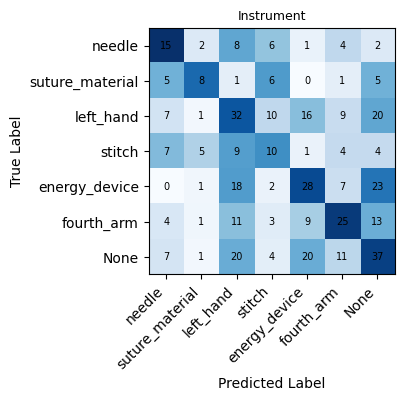

In [78]:
n_rows, n_cols = 1, 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.2 * n_cols, 3.2 * n_rows))

i_cm = np.array(i_metrics['confusion_matrix'])
plot_confusion_matrix_row_normalized(axes, i_cm, i_metrics['confusion_matrix_labels'], 'Instrument')

plt.show()

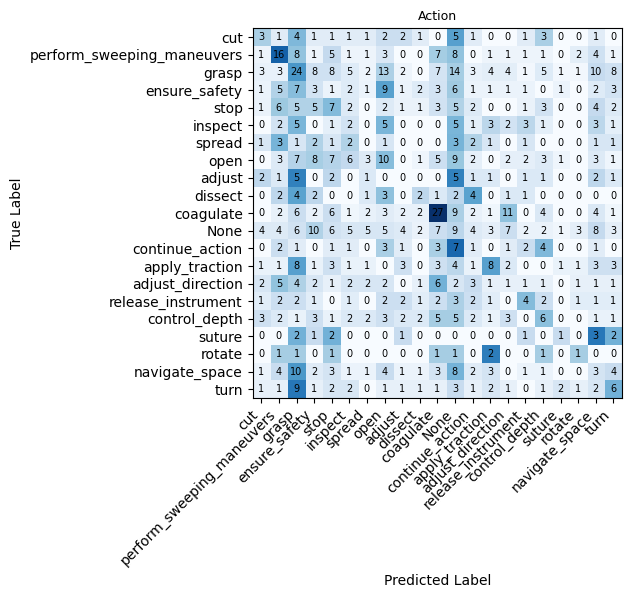

In [79]:
n_rows, n_cols = 1, 1
fig, axes = plt.subplots(n_rows, n_cols)

a_cm = np.array(a_metrics['confusion_matrix'])
plot_confusion_matrix_row_normalized(axes, a_cm, a_metrics['confusion_matrix_labels'], 'Action')

plt.show()

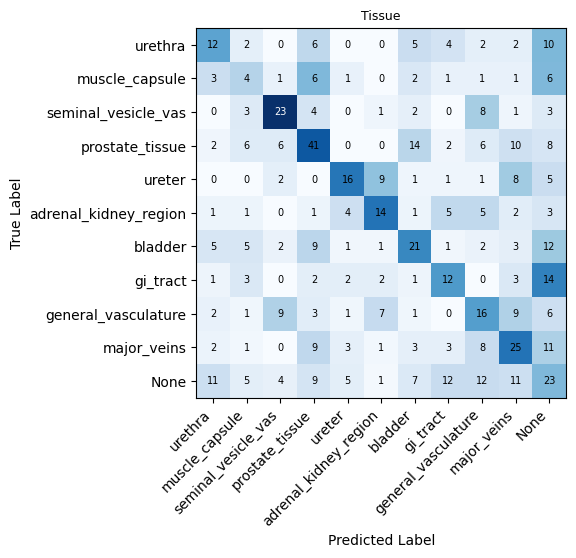

In [80]:
fig, axes = plt.subplots(n_rows, n_cols)

t_cm = np.array(t_metrics['confusion_matrix'])
plot_confusion_matrix_row_normalized(axes, t_cm, t_metrics['confusion_matrix_labels'], 'Tissue')

plt.show()

### Fusion Models

In [104]:
iat_metrics_dir = '../../outputs/iat_metrics'
tasks = ['instrument', 'action', 'tissue']
fusion_models = ['lstm_fusion', 'cross_transformer', 'ffn_fusion']
model = 'peskavlp'
input = 'vision+procedure+task+tracks'
num_none = 100
num_tracks = 15

auc_scores = {}
f1_scores = {}
precision_scores = {}
recall_scores = {}

metrics_rows = []

for task in tasks:
    auc_scores[task] = {}
    f1_scores[task] = {}
    precision_scores[task] = {}
    recall_scores[task] = {}
    for fusion_model in fusion_models:
        file = f'{task}-{model}-{input}-none={num_none}-num_tracks={num_tracks}-{fusion_model}.json'
        path = os.path.join(iat_metrics_dir, file)
        with open(path, 'r') as f:
            metrics = json.load(f)
        auc_scores[task][fusion_model] = metrics['auroc_mean']
        f1_scores[task][fusion_model] = metrics['f1_mean']
        precision_scores[task][fusion_model] = metrics['precision_mean']
        recall_scores[task][fusion_model] = metrics['recall_mean']

        metrics_rows.append({
            'task': task,
            'fusion_model': fusion_model,
            'auc_score': metrics['auroc_mean'],
            'auc_std': np.std(metrics['auroc_scores']),
            'f1_score': metrics['f1_mean'],
            'f1_std': np.std(metrics['f1_scores']),
            'precision_score': metrics['precision_mean'],
            'precision_std': np.std(metrics['precision_scores']),
            'recall_score': metrics['recall_mean'],
            'recall_std': np.std(metrics['recall_scores'])
        })

metrics_df = pd.DataFrame(metrics_rows)
metrics_df.round(2)

,task,fusion_model,auc_score,auc_std,f1_score,f1_std,precision_score,precision_std,recall_score,recall_std
0,instrument,lstm_fusion,0.71,0.02,0.34,0.03,0.36,0.05,0.35,0.04
1,instrument,cross_transformer,0.56,0.04,0.18,0.07,0.19,0.08,0.20,0.04
2,instrument,ffn_fusion,0.63,0.03,0.23,0.03,0.23,0.03,0.23,0.03
3,action,lstm_fusion,0.61,0.02,0.11,0.01,0.12,0.01,0.12,0.02
4,action,cross_transformer,0.54,0.03,0.05,0.01,0.06,0.01,0.06,0.01
5,action,ffn_fusion,0.56,0.01,0.08,0.01,0.08,0.01,0.08,0.01
6,tissue,lstm_fusion,0.77,0.01,0.34,0.04,0.36,0.04,0.34,0.03
7,tissue,cross_transformer,0.58,0.01,0.12,0.01,0.12,0.01,0.13,0.01
8,tissue,ffn_fusion,0.67,0.02,0.24,0.04,0.25,0.04,0.25,0.04


### Multiple Instance Training

In [114]:
tasks = ['instrument', 'action', 'tissue']
print("AUROC:")
for task in tasks:
    iat_metrics_path = f'/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/outputs/iat_metrics/{task}-peskavlp-vision+procedure+task+tracks-none=100-num_tracks=15-multiple_instance_training-voting.json'

    with open(iat_metrics_path, 'r') as f:
        iat_metrics = json.load(f)

    print(f"{task} - {iat_metrics['auroc_mean']:.2f} +/- {np.std(iat_metrics['auroc_scores']):.2f}")

AUROC:
instrument - 0.73 +/- 0.02
action - 0.62 +/- 0.02
tissue - 0.79 +/- 0.02
